In [ ]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array

# load doc into memory

def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs

# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	#re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	#table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			#line = normalize('NFD', line).encode('ascii', 'ignore')
			#line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			#line = [word.lower() for word in line]
			# remove punctuation from each token
			#line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			#line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			#line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
filename = '/content/ben.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')
# spot check
for i in range(100):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl
[go] => [যাও।]
[go] => [যান।]
[go] => [যা।]
[run] => [পালাও]
[run] => [পালান]
[who] => [কে]
[fire] => [আগুন]
[help] => [বাঁচাও]
[help] => [বাঁচান]
[stop] => [থামুন]
[stop] => [থামো]
[stop] => [থাম]
[hello] => [নমস্কার]
[i see] => [বুঝলাম।]
[i try] => [আমি চেষ্টা করি।]
[smile] => [একটু হাসুন।]
[smile] => [একটু হাসো।]
[attack] => [আক্রমণ]
[get up] => [ওঠো।]
[get up] => [উঠুন।]
[got it] => [বুঝে গেছি]
[got it] => [ধরেছি]
[got it] => [বুঝেছো]
[got it] => [বুঝেছেন]
[got it] => [বুঝেছিস]
[i know] => [আমি জানি।]
[i know] => [আমার জানা আছে।]
[i lost] => [আমি হেরে গেছি।]
[im 19] => [আমার ১৯ বছর বয়স।]
[im ok] => [আমি ঠিক আছি।]
[listen] => [শোন।]
[listen] => [শুনুন।]
[no way] => [কোন মতেই না]
[really] => [সত্যি]
[really] => [তাই নাক]
[thanks] => [ধন্যবাদ।]
[try it] => [চেখে দেখুন।]
[try it] => [চেখে দেখো।]
[we won] => [আমরা জিতে গেছে।]
[why me] => [আমিই কেন]
[ask tom] => [টমকে জিজ্ঞাসা করো।]
[ask tom] => [টমকে জিজ্ঞাসা করুন।]
[ask tom] => [টমকে জিজ্ঞাসা কর।]
[call me] =

In [ ]:
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')

# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[1000:]
# save
save_clean_data(dataset, 'english-g-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


In [ ]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:,0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

English Vocabulary Size: 1875
English Max Length: 19
German Vocabulary Size: 3310
German Max Length: 18
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 18, 256)           847360    
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 19, 256)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 19, 256)           525312    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 19, 1875)          481875    
Total params: 2,379,859
Trainable params: 2,379,859
Non-trainable params: 0
_________________________________________________________________
None
E

In [ ]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src,test = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

# load model
model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[উনি কথা বলছিলেন।], target=[he was speaking], predicted=[he was speaking]
src=[ওরা পরোয়া করে না।], target=[they dont care], predicted=[they dont care]
src=[টম মেরিকে হুমকি দিলো।], target=[tom threatened mary], predicted=[tom threatened mary]
src=[ফুলদানিটা কে ভাঙল], target=[who broke the vase], predicted=[who broke the vase]
src=[টম বারে দাঁড়িয়ে বিয়ার খাচ্ছিল।], target=[tom was standing at the bar having a beer], predicted=[tom was standing at the bar drinking a beer]
src=[আমি বেকারিতে গেলাম।], target=[i went to the bakery], predicted=[i went to the bakery]
src=[তুমি কি মাংস খাও], target=[do you eat meat], predicted=[do you eat meat]
src=[আরও চেষ্টা কর।], target=[try hard], predicted=[try hard]
src=[আমি ঠিক বুঝতে পরছি না।], target=[i do not understand], predicted=[i dont get it]
src=[ওকে ফ্যাকাসে দেখাচ্ছে।], target=[he looks pale], predicted=[he looks pale]
BLEU-1: 0.946882
BLEU-2: 0.923017
BLEU-3: 0.893905
BLEU-4: 0.822678
test
src=[আপনি কে], target=[who are you], predic

In [ ]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src,test = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load datasets
dataset = load_clean_sentences('english-bangla-both.pkl')
train = load_clean_sentences('english-bangla-train.pkl')
test = load_clean_sentences('english-bangla-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare Bengali tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

# load model
model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

In [ ]:
# load data
filename = '/content/ct.txt'
file = open(filename, 'rt')
text = file.read()
file.close()
# split into words
from nltk.tokenize import word_tokenize
tokens = word_tokenize(text)
# stemming of words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
stemmed = [porter.stem(word) for word in tokens]
print(stemmed[:2000])

['\ufeff', '1.আঁই', 'ন', 'গইজ্জুম', '2.তোঁয়ারা', 'গম', 'আছনে', '?', '৩।', 'অঁনে', 'গম', 'আছন্নে', '?', '৪।অনরা', 'কেন', 'আছন', '?', '৫।ইতারা', 'কেং', 'গরের', '?', '৬/আঁর', 'বাড়ি', 'খাসসবাজার', '৭/ইন', 'ইতে', 'চাইয়েদেরী', '৮/আই', 'কেং', 'গইরত্তাম', '৯/কুঁইইরে', 'হঅরাইইয়ে', '১০/মুশা', 'হঅরার', 'দে', 'আঁরে', '১১/বিলাই', 'মাছ', 'চুরি', 'গরি', 'খাই', 'ফেলাইয়ে', 'দে', '১২/দিয়া', 'ফইল্লে', 'দি', 'ফেল', 'গই', '১৩/আঁই', 'কি', 'হইতাম', 'এরে', '১৪/ইতারা', 'গম', 'মারেদ্দে', '১৫/বিইন্না', 'ভাত', 'খাই', '১৬/দুইজ্জা', 'হাআলি', 'ইছা', 'মাছ', 'দিই', 'অরে', 'ভাত', 'খাইই', 'দেএরি', '১৭/আছরত্তত', 'আইসসুম', 'আঁই', '১৮/', 'তেইল্যাচুরা', 'লাই', 'কিছু', 'রাখিত', 'ন', 'পারির', '১৯/টুট', 'টুই', 'ঢাহেদ্দে', 'আ', '২০/হাট্টল', 'খাইওস', 'নে', '?', '২১১/ইতাত্তো', 'বাজমালর', 'দোয়ান', 'আছে', '২১/বেজ্ঞিন', 'ঘটি', 'যার', 'গই', '২২/', 'ইতে', 'বিয়া', 'গইজ্জে', '২৩/তুয়ার', 'গিন', 'তুয়ারে', 'দি', 'ফেলাই', '২৪/মধুপুক', 'অর', 'মধু', 'ইন', '২৫/', 'আঁই', 'খুইশুল', 'খাইইমু', '২৬/আইজ্জা', 'কি', 'রাইন্ধঅ', '?', '২৭/এত', 'মাছর', 'ম

In [ ]:
# load data
filename = '/content/T.txt'
file = open(filename, 'rt')
text = file.read()
file.close()
# split into words
from nltk.tokenize import word_tokenize
tokens = word_tokenize(text)
# stemming of words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
stemmed = [porter.stem(word) for word in tokens]
print(stemmed[:2000])

['\ufeff1.আঁই', 'ন', 'গইজ্জুম-আমি', 'করব', 'না', '2.তোঁয়ারা', 'গম', 'আছনে', '?', '-', 'তোমরা', 'ভাল', 'আছ', '?', '৩।', 'অঁনে', 'গম', 'আছন্নে', '?', '-', 'আপনি', 'ভাল', 'আছেন', '?', '৪।অনরা', 'কেন', 'আছন', '?', '-', 'আপনারা', 'কেমন', 'আছেন', '?', '৫।ইতারা', 'কেং', 'গরের', '?', '-', 'তারা', 'কি', 'করছে', '?', '৬/আঁর', 'বাড়ি', 'খাসসবাজার-', 'আমার', 'বাড়ি', 'কক্সবাজার', '?', '৭/ইন', 'ইতে', 'চাইয়েদেরী-সে', 'এটা', 'চাইছে', '৮/আই', 'কেং', 'গইরত্তাম-', 'আমি', 'কি', 'করব', '৯/কুঁইইরে', 'হঅরাইইয়ে-', 'কুকুর', 'এ', 'কামড়াইছে', '১০/মুশা', 'হঅরার', 'দে', 'আঁরে-', 'আমাকে', 'মশা', 'কামড়াচ্ছে', '১১/বিলাই', 'মাছ', 'চুরি', 'গরি', 'খাই', 'ফেলাইয়ে', 'দে', '-বিড়াল', 'মাছ', 'চুরি', 'করে', 'খেয়ে', 'ফেলেছে', '১২/দিয়া', 'ফইল্লে', 'দি', 'ফেল', 'গই-যার', 'যা', 'মুল্য', 'প্রাপ্র্য', '১৩/আঁই', 'কি', 'হইতাম', 'এরে-আমি', 'কি', 'বলতাম', 'এখানে', '১৪/ইতারা', 'গম', 'মারেদ্দে-', 'তারা', 'গল্প', 'করছে।', '১৫/বিইন্না', 'ভাত', 'খাই-সকালে', 'ভাত', 'খাই', '১৬/দুইজ্জা', 'হাআলি', 'ইছা', 'মাছ', 'দিই', 'অরে', 'ভাত', 'খাইই', 'দেএর

In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# load data
filename = '/content/ct.txt'
file = open(filename, 'rt')
text = file.read()
file.close()
# split into words
from nltk.tokenize import word_tokenize
tokens = word_tokenize(text)
# convert to lower case
tokens = [w.lower() for w in tokens]
# remove punctuation from each word
import string
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in tokens]
# remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]
# filter out stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words]
print(words[:2000])

['ন', 'গম', 'গম', 'আছন', 'গই', 'গম', 'ন', 'আ', 'গই', 'অর', 'ইন', 'গম', 'ডঅর', 'ছ', 'লই', 'ছইড', 'ন', 'ন', 'ন', 'ন', 'ন', 'এহন', 'গম', 'ন', 'শহরত', 'ভর', 'ন', 'যঅর', 'ন', 'মনত', 'ন', 'অর', 'ঢল', 'গরর', 'গম', 'ন', 'ন', 'বইঅ', 'দ', 'গই', 'ডর', 'আ', 'তয়', 'খইঅ', 'খঅ', 'গরর', 'গম', 'আছ', 'ন', 'ন', 'অইব', 'বই', 'এন', 'গরর', 'চঅন', 'হঅমন', 'ইনর', 'এন', 'গরর', 'ন', 'বইন', 'গম', 'গম', 'অ', 'ধইল', 'রইঅস', 'অউর', 'খস', 'তর', 'গরস', 'আইওন', 'গরন', 'হবর', 'গই', 'অলত', 'বই', 'গম', 'ঝড়', 'ন', 'গরর', 'গরর', 'গম', 'খঅর', 'গই', 'লই', 'চরত', 'পর', 'ঘরর', 'নঅ', 'ন', 'ন', 'গম', 'গম', 'ডর', 'লই', 'যহন', 'ন']


In [ ]:
# load data
filename = '/content/T.txt'
file = open(filename, 'rt')
text = file.read()
file.close()
# split into words
from nltk.tokenize import word_tokenize
tokens = word_tokenize(text)
# convert to lower case
tokens = [w.lower() for w in tokens]
# remove punctuation from each word
import string
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in tokens]
# remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]
# filter out stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words]
print(words[:2000])

['ন', 'করব', 'গম', 'আছ', 'গম', 'আছন', 'করব', 'এ', 'গম', 'আসব', 'ন', 'আ', 'গইসব', 'অর', 'আখ', 'গম', 'ডঅর', 'বড়', 'ছ', 'লই', 'ছইড', 'ন', 'হয়', 'হইও', 'ন', 'ন', 'ন', 'সব', 'সব', 'ন', 'সব', 'এখন', 'সব', 'গম', 'ন', 'ভর', 'ন', 'যঅর', 'কর', 'কর', 'ন', 'মনত', 'ন', 'করব', 'অর', 'ঢল', 'ঢল', 'গররবড়', 'আর', 'করছ', 'আ', 'গম', 'গম', 'ভয়', 'ন', 'করব', 'ই', 'ন', 'বইঅ', 'বস', 'এর', 'দ', 'ত', 'ডর', 'ভয়', 'ভয়', 'আ', 'তয়', 'বলব', 'খইঅ', 'বলছ', 'বলছ', 'বল', 'গরর', 'করছ', 'গম', 'আছ', 'আছ', 'ন', 'এত', 'ন', 'বই', 'এক', 'এন', 'গরর', 'এমন', 'করছ', 'কখন', 'কত', 'চঅন', 'ইনর', 'এরকম', 'এন', 'গরর', 'এরকম', 'ন', 'বইন', 'গম', 'গম', 'অ', 'কর', 'ধইল', 'রইঅস', 'এরকম', 'আছ', 'পড়', 'অউর', 'খস', 'তর', 'গরস', 'কর', 'আইওন', 'আসব', 'গরন', 'হবর', 'খবর', 'গই', 'অলত', 'কখন', 'হয়', 'গম', 'ঝড়', 'ন', 'গরর', 'করছ', 'গরর', 'এখন', 'করছ', 'খঅর', 'সব', 'সব', 'লই', 'আসব', 'চরত', 'পর', 'পর', 'ঘরর', 'নঅ', 'ন', 'ন', 'এমন', 'গম', 'গম', 'ডর', 'লই', 'যহন', 'যখন', 'তখন', 'ন', 'আর', 'আর', 'ন', 'এত', 'বড়', 'ন', 'বসব', 'ত', 'ছ', 'বয়', 'বস', 'আসব',

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

['Hello Mr. Smith, how are you doing today?', 'The weather is great, and city is awesome.', 'The sky is pinkish-blue.', "You shouldn't eat cardboard"]
['Hello', 'Mr.', 'Smith', ',', 'how', 'are', 'you', 'doing', 'today', '?', 'The', 'weather', 'is', 'great', ',', 'and', 'city', 'is', 'awesome', '.', 'The', 'sky', 'is', 'pinkish-blue', '.', 'You', 'should', "n't", 'eat', 'cardboard']
<FreqDist with 25 samples and 30 outcomes>


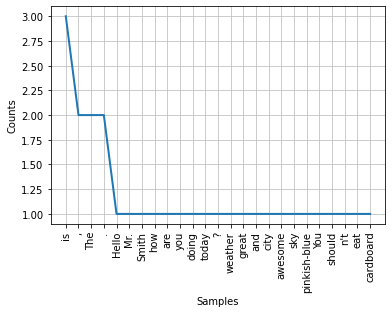

{'needn', 'whom', 'how', 'out', 'here', 'them', 'are', 'above', 'up', 'all', "couldn't", 'why', 'his', 'a', 'they', 'wouldn', 'i', 'than', 'couldn', "doesn't", 'he', 'our', 'ain', 'wasn', 'too', 'having', 're', 'ours', 'himself', 'your', 'yourself', 'own', 'any', 'for', 'because', 'doing', 's', 'an', 'now', 'aren', 'at', 'doesn', 'about', 'when', 'we', 'each', 'hers', 'didn', "you're", "aren't", 'below', 'on', 'what', 'has', 'have', 've', 'it', 'y', 'was', 'him', "shouldn't", 'hasn', 'yourselves', 'again', 'nor', 'theirs', 'did', 'under', 't', 'the', 'yours', 'me', 'is', 'in', 'such', "wasn't", 'o', 'will', "needn't", 'won', 'by', 'my', 'off', 'once', "you'll", 'be', 'ourselves', "she's", 'ma', 'that', 'were', "it's", "hasn't", 'isn', "won't", 'other', 'do', 'shan', "that'll", 'down', "didn't", 'itself', 'most', 'can', 'between', "isn't", 'themselves', 'who', 'as', 'from', 'or', 'over', 'of', 'which', 'does', 'been', 'myself', 'these', 'after', "mustn't", 'few', 'd', "mightn't", 'don',

In [ ]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
text="""Hello Mr. Smith, how are you doing today? The weather is great, and city is awesome.
The sky is pinkish-blue. You shouldn't eat cardboard"""
tokenized_text=sent_tokenize(text)
print(tokenized_text)
tokenized_word=word_tokenize(text)
print(tokenized_word)
fdist = FreqDist(tokenized_word)
print(fdist)
fdist.most_common(2)

fdist.plot(30,cumulative=False)
plt.show()

stop_words=set(stopwords.words("english"))
print(stop_words)


In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
sent = "আঁই ন গইজ্জুম|"
tokens=nltk.word_tokenize(sent)
print(tokens)
nltk.pos_tag(tokens)

['আঁই', 'ন', 'গইজ্জুম|']


[('আঁই', 'JJ'), ('ন', 'NNP'), ('গইজ্জুম|', 'NN')]

In [ ]:
 import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, data['Sentiment'], test_size=0.3, random_state=1)

In [ ]:
 import nltk
 nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
  import nltk
  nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
  import nltk
  nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
# define documents
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.']
# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])
# integer encode the documents
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

[[36, 27], [30, 8], [49, 30], [27, 8], [14], [34], [37, 30], [32, 30], [37, 8], [48, 25, 27, 1]]
[[36 27  0  0]
 [30  8  0  0]
 [49 30  0  0]
 [27  8  0  0]
 [14  0  0  0]
 [34  0  0  0]
 [37 30  0  0]
 [32 30  0  0]
 [37  8  0  0]
 [48 25 27  1]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 8)              400       
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: 89.999998
